In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm

In [3]:
data = pd.read_excel('ExampleMultipleRegression.xlsx', 'data', index_col=None, na_values=['NA'])

-  Monthly Data from July 1963 to July 2023

VARIABLES:

- Large cap : 10th decile by market equity

- MKTminRF : Market – Risk-Free

- SMB - the Small-Minus-Big **size factor** - Effetto dimensione: small – big cap
- HML - the High-Minus-Low **Book-to-Market factor** - Effetto valore: value – growth
- MOM - the **Momentum factor** 
- RMW - the Robust-Minus-Weak **Operating profitability factor** - Redditività operativa
- CMA - the Conservative-Minus-Aggressive **investment portfolios factor** - Politica di investimento
- RF - the Risk-Free rate

In [4]:
# Definizione variabili

Y = data['LARGE'] - data['RF']
x = data[["MKTminRF", "SMB", "HML", "RMW", "CMA", "MOM"]]

# intercetta
X = sm.add_constant(x)

multimodel = sm.OLS(Y, X).fit()
print(multimodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.090e+04
Date:                Thu, 09 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:33:29   Log-Likelihood:                -439.20
No. Observations:                 721   AIC:                             892.4
Df Residuals:                     714   BIC:                             924.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0199      0.018      1.126      0.2

| Fattore       | Coefficiente (β) | p-value | Interpretazione                                                                                                      |
| ------------- | ---------------- | ------- | -------------------------------------------------------------------------------------------------------------------- |
| **α (const)** | 0.0199           | 0.260   | **non significativo** → nessun extra rendimento medio non spiegato                                                       |
| **MKTminRF**  | 0.9819           | 0.000   | molto significativo → portafoglio large cap si muove quasi come il mercato                                           |
| **SMB**       | -0.2619          | 0.000   | significativo → portafoglio large cap ha esposizione negativa al fattore size (cioè si comporta come grandi aziende) |
| **HML**       | -0.0148          | 0.067   | marginale → leggera esposizione negativa al fattore value (più growth-oriented)                                      |
| **RMW**       | 0.0420           | 0.000   | significativo → correlazione positiva con titoli ad alta redditività operativa                                       |
| **CMA**       | -0.0029          | 0.807   | **non significativo** → nessuna relazione chiara con politiche di investimento (conservative/aggressive)                 |
| **MOM**       | -0.0050          | 0.233   | **non significativo** → il fattore momentum non spiega i rendimenti large cap                                            |

| Test                                | Risultato                                              |
| ----------------------------------- | ------------------------------------------------------ |
| **Durbin-Watson = 1.887**           | ≈2 → nessuna autocorrelazione seriale dei residui      |
| **Omnibus / Jarque–Bera (p=0.001)** | residui non perfettamente normali (leggera asimmetria) |
| **Skew ≈ 0 / Kurtosis > 3**         | residui leggermente leptocurtici (code più spesse)     |



Implicazioni dell'inclusione di Variabili non significarive

- il coefficiente R2 può aumentare leggermente, ma senza reale valore esplicativo.

- Se correlate con altri regressori (collinearita) --> aumento degli ERRORI STANDARD (NOISE)= Incertecca sulla stima dei parametri

- Variabili poco significative possono spiegare meglio il campione di dati, ma riducono la capacità predittiva e di adattamento a nuovi campioni

In [5]:
Z = X.drop(columns=["CMA", "MOM", "HML"])

multimodel_clean = sm.OLS(Y, Z).fit()
print(multimodel_clean.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.165e+04
Date:                Thu, 09 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:33:34   Log-Likelihood:                -443.21
No. Observations:                 721   AIC:                             894.4
Df Residuals:                     717   BIC:                             912.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.017      0.624      0.5

- R2 invariato
- Errori Standard diminuiti

### MODEL COMPARSION

- Multimodel = 6 regressors
- Clean Model = 3 regressors

3 Restrictions:

H0 : βHML ​= βCM A​= βMOM ​= 0      

#### TEST-F - confronta la capacità esplicativa dei due modelli

- **se rimuovere quelle variabili NON modifica l’errore (RSS), allora i fattori non erano importanti → Non rifiuto H0**

- p-value > 0.05 Variabili non significative - Non rifiuto H0


### F = [ (RSSr - RSSu) / q ] / [RSSu /  (n - k)]

RSSR = somma dei residui del modello ristretto

RSSU = somma dei residui del modello completo

q = numero di restrizioni (variabili eliminate = 3)

n = numero di osservazioni

k = numero di parametri nel modello completo (inclusa l’intercetta)


In [17]:
k = (len(data) - 7)     # numwber of observations - number of parameters estimated (6 betas + 1 alpha)
q = 3

In [18]:
RSSU = multimodel.ssr
RSSR = multimodel_clean.ssr
Fstat = ((RSSR - RSSU)/q) / (RSSU/(k))
Pval = 1 - sp.stats.f.cdf(Fstat, q, k)

print("F-statistic: ", Fstat)
print("P-value: ", Pval)


F-statistic:  2.6649688945731778
P-value:  0.04692909465170658


un p-value così vicino al limite non fornisce una prova solida per rifiutare H0

F - stat mostra un piccolo miglioramento nel fit del modello

### DIAGNOSTIC ON VARIABLES - Multicollinearity

- Correlation Matrix

- VIF (1 / 1-R2adj)

| VIF   | Livello di collinearità        |
| ----- | ------------------------------ |
| = 1   | nessuna                        |
| 1 – 5 | accettabile                    |
| > 5   | moderata                       |
| > 10  | **grave multicollinearità**    |


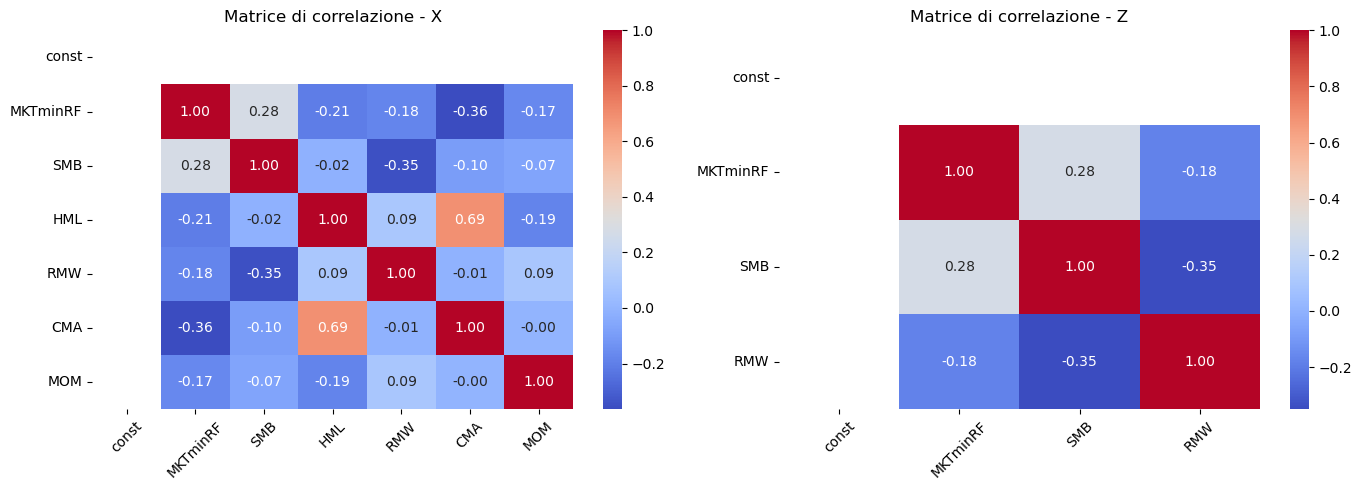

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prima heatmap: correlazione di X
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0])
axes[0].set_title("Matrice di correlazione - X")
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Seconda heatmap: correlazione di Z
sns.heatmap(Z.corr(), annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1])
axes[1].set_title("Matrice di correlazione - Z")
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

# Migliora la disposizione
plt.tight_layout()
plt.show()

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["variables"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data.round(2)

In [ ]:
vif_X = calculate_vif(X)
vif_Z = calculate_vif(Z)

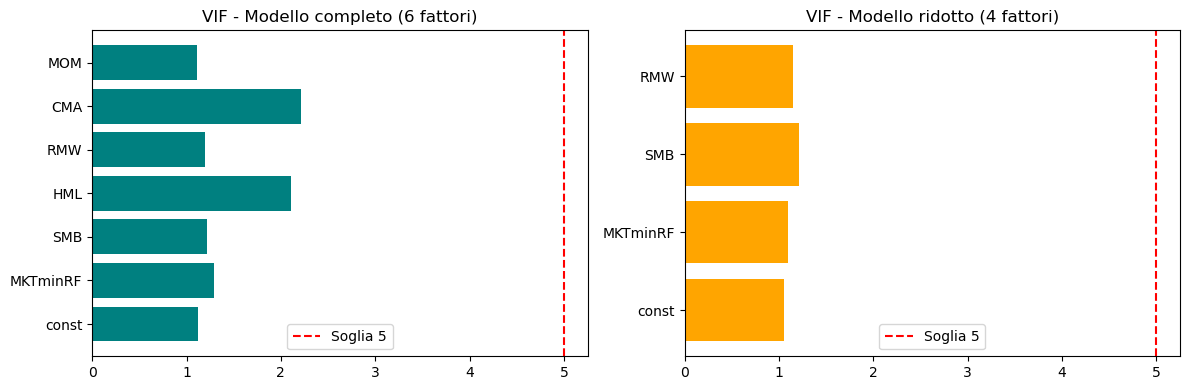

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].barh(vif_X["variables"], vif_X["VIF"], color="teal")
axes[0].axvline(5, color="r", linestyle="--", label="Soglia 5")
axes[0].set_title("VIF - Modello completo (6 fattori)")
axes[0].legend()

axes[1].barh(vif_Z["variables"], vif_Z["VIF"], color="orange")
axes[1].axvline(5, color="r", linestyle="--", label="Soglia 5")
axes[1].set_title("VIF - Modello ridotto (4 fattori)")
axes[1].legend()

plt.tight_layout()
plt.show()


## DIAGNOSTIC ON FUNCTIONAL FORM

To evaluate the appropriateness of the linear specification we use:

### RESET - Ramsey Test

it consist on making an F-stat between the linear model and an auxiliary regression in which we put non linear coefficent of the fitted values

**H0: non linear coeff = 0** - If p-value < 0,05 the non linear coeff. are statistically significant


### The non linearity can be derived from different sides


| Tipo di non linearità            | Esempio                     | Effetto                                      |
| -------------------------------- | --------------------------- | -------------------------------------------- |
| **Quadratica o curvilinea**      | (Xi^2)                      | Effetto marginale del mercato non costante   |
| **Logaritmica**                  | (\ln(Xi))                   | Relazione proporzionale o saturazione        |
| **Interazione**                  | (Xi * Xj)                   | Effetti combinati tra fattori                |
| **Structural break**             | effetto cambia oltre soglia | Reazione diversa in bull vs bear markets     |
| **Fattori omessi**               | assenza di Xj               | Modello incompleto (non linearità apparente) |


### CHOW Test

Verification of structural break, by dividing the sample of observation in two sub-sample, /n
then we conduct an F-Stat between RSS of the original model and the SSR of the sum of the 2 sub-model

**if P-value > 0,05 --> we have significance on structural break**

#### PROBLEM: Where is situated the break point in the time-series??

- we run the test for different break dates and store the p-value of each one

- Plot the p-value over time

- The date in which we have the max / min p-value is the best candidate

## DIAGNOSTIC ON RESIDUALS

We must evaluate 2 things derived from the Hypothesis under Linear Model:

1. The Omoschedasticity - la varianza degli errori deve essere **costante per tutte le osservazioni**

    - #### Breush-Pagan Test -->    Regression on residuals



2. The Independence between residual - Absence of Autocorrelation COV(Ei, Ej) = 0

    - #### Durbin Watson - Autocorrelation of first order (Et - Et-1)

        - DW ≈ 2 → indipendenza (nessuna autocorrelazione)

        - DW < 2 → autocorrelazione positiva

        - DW > 2 → autocorrelazione negativa


    - #### Breush-Godfrey - AR > 1
    


#### Breush-Pagan

- model.resid = calcola i residui del modello
- model.exog = eleva al quadrato e li segredisce sui regressori

LM = Lagrange multiplier (equivalent to the F-Stat)


Il p-value ≈ 0.50 >> 0.05 → non rifiutiamo H0



In [6]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(multimodel.resid, multimodel.model.exog)
labels = ['LM stat', 'LM p-value', 'F-stat', 'F p-value']
print(dict(zip(labels, bp_test)))

{'LM stat': 5.317750096496825, 'LM p-value': 0.5037517330439549, 'F-stat': 0.8842084061305717, 'F p-value': 0.5058988486792582}


### Durbin-Watson

DW = 1.887 è molto vicino a 2, quindi non emergono segnali di correlazione seriale significativa tra gli errori

In [8]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(multimodel.resid)
print("Durbin-Watson:", dw)

Durbin-Watson: 1.887243824983864


### Breush-Godfrey

Crea una regressione ausiliaria dove i residui vengono regrediti su:

- Tutti i regressori originali

- su alcuni ritardi (lag) dei residui stessi (fino a nlags=4)

p-value ≈ 0.21 > 0.05 → non rifiutiamo H0 - non c’è evidenza di correlazione seriale fino al 4° ordine.

In [10]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

bg_test = acorr_breusch_godfrey(multimodel, nlags=4)
labels = ['LM stat', 'p-value', 'F stat', 'F p-value']
print(dict(zip(labels, bg_test)))


{'LM stat': 5.909191216254145, 'p-value': 0.20603334375628884, 'F stat': 1.4667807612700963, 'F p-value': 0.21053721922894345}


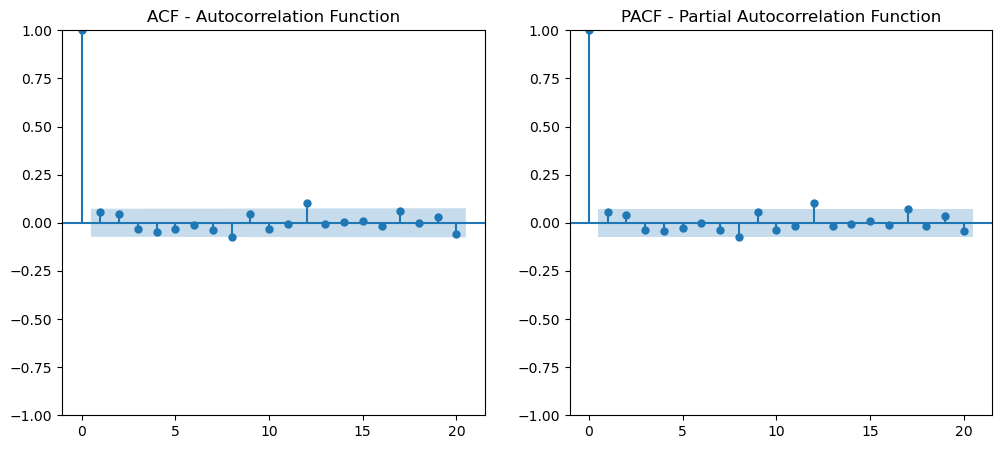

In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

resid = multimodel.resid  # residui del modello stimato

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(resid, lags=20, ax=plt.gca())
plt.title("ACF - Autocorrelation Function")

plt.subplot(1,2,2)
plot_pacf(resid, lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF - Partial Autocorrelation Function")
plt.show()


Caso ideale – Rumore bianco

Tutti i coefficienti ACF e PACF (tranne il primo)
restano dentro le bande blu (limiti di confidenza

### EXERCISE ON DJJA

Select a stock from djja and perform a regression by using factors

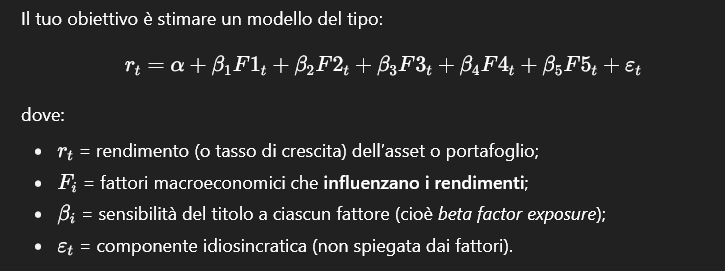


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm

# ------------------------------------------------------------------------------------
# load stock prices
data = pd.read_excel('DJIA.xlsx', 'DJIA', index_col='DATE', na_values=['NA'])
# load factors
factors = pd.read_excel('DJIA.xlsx', 'Factors', index_col='DATE', na_values=['NA'])




### PROBLEMA DATE INDEX

I fogli presentano date in formato diverso --> Necessario uniformare

1. Importiamo la lingua italiana perchè nel file DJJIA i mesi sono in italiano

2. Modifihiamo il dataframe factor 
    - format = %b %Y dice a pandas che le date sono nel formato “Mese abbreviato + Anno” (es. “Dic 1999”, “Jan 2001”).
    - .to_period('M').to_timestamp('M') → trasforma il periodo mensile nel timestamp dell’ultimo giorno del mese.

3. Modifichiamo il dataframe data --> da gg/mm/aaaa a aaaa/mm/gg

4. Verifichiamo che le date corrispondano

In [55]:
import locale
locale.setlocale(locale.LC_TIME, 'it_IT.UTF-8')  # imposta lingua italiana

factors.index = pd.to_datetime(factors.index, format='%b %Y', errors='coerce').to_period('M').to_timestamp('M')# select data for one company 

data.index = pd.to_datetime(data.index, errors='coerce').to_period('M').to_timestamp('M')


print(data.index.equals(factors.index))


True


In [ ]:
P=data[['APPLE']]
Y=100*(np.log(P)-np.log(P.shift(1)))


# select data of explanatory variables
F1=factors[['Crude Oil-WTI Spot Cushing U$/BBL']]
F2=factors[['US $ TO EURO (WMR) - EXCHANGE RATE']]
F3=factors[['US CPI - ALL URBAN: ALL ITEMS SADJ']]
F4=factors[['US UNEMPLOYMENT RATE SADJ']]
F5=factors[['US INDUSTRIAL PRODUCTION - TOTAL INDEX VOLA']]

# log-returs (growth rates) for F1, F2, F3, F5
X1=100*(np.log(F1)-np.log(F1.shift(1)))
X2=100*(np.log(F2)-np.log(F2.shift(1)))
X3=100*(np.log(F3)-np.log(F3.shift(1)))
X5=100*(np.log(F5)-np.log(F5.shift(1)))

# first difference for F4
X4=np.log(F4)-np.log(F4.shift(1))


| Fattore                                     | Descrizione                                           | Interpretazione economica                                                                                                              |
| ------------------------------------------- | ----------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **F1 – Crude Oil (WTI)**                    | Prezzo del petrolio greggio (West Texas Intermediate) | Misura l’impatto dei **prezzi energetici**. Un aumento del petrolio può aumentare i costi di produzione e ridurre i margini aziendali. |
| **F2 – US$/Euro Exchange Rate**             | Tasso di cambio USD/EUR                               | Riflette la **forza del dollaro**. Un dollaro forte penalizza le aziende esportatrici USA, un dollaro debole le favorisce.             |
| **F3 – CPI (Consumer Price Index)**         | Inflazione (Indice dei prezzi al consumo)             | Indica la **pressione inflazionistica**. Inflazione alta può ridurre i profitti e influenzare i tassi d’interesse.                     |
| **F4 – Unemployment Rate**                  | Tasso di disoccupazione USA                           | Proxy del **ciclo economico**. Disoccupazione bassa = crescita forte; alta = recessione.                                               |
| **F5 – Industrial Production (Volatility)** | Indice della produzione industriale (volatilità)      | Misura la **variabilità dell’attività produttiva** → indicatore di instabilità economica.                                              |


In [66]:
# 4️⃣ Allineamento temporale e pulizia
data_reg = pd.concat([Y, X1, X2, X3, X4, X5], axis=1, join='inner').dropna()
data_reg.columns = ['Y', 'X1', 'X2', 'X3', 'X4', 'X5']

# 5️⃣ Regressione OLS
Y = data_reg['Y']
X = sm.add_constant(data_reg[['X1', 'X2', 'X3', 'X4', 'X5']])

Res1 = sm.OLS(Y, X).fit()
print(Res.summary())
# recover fitted values and residuals
fit1=Res1.fittedvalues
resid1=Res1.resid

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.080
Date:                gio, 09 ott 2025   Prob (F-statistic):            0.00135
Time:                        18:59:52   Log-Likelihood:                -1140.8
No. Observations:                 297   AIC:                             2294.
Df Residuals:                     291   BIC:                             2316.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7762      0.819      2.169      0.0

X2 - X3 Non significativi P-value > 0.05

DW = 1.8 no correlazione dei residui


### Verifiche

- Multicollineaità
- Linearità --> RESET
- Omoschedasticità --> Breush Pagan

In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif["Variable"] = Res1.model.exog_names
vif["VIF"] = [variance_inflation_factor(Res1.model.exog, i)
              for i in range(Res1.model.exog.shape[1])]
print(vif)

  Variable       VIF
0    const  1.535643
1       X1  1.204861
2       X2  1.077516
3       X3  1.172335
4       X4  2.428255
5       X5  2.437507


In [ ]:
# RESET test
# Auxiliary regression
XR = np.column_stack((np.ones_like(Y), X1, X2, X3, X4, X5, np.power(fit1,2), np.power(fit1,3)))
Res2 = sm.OLS(Y, XR).fit()
# test
RSSR=Res1.ssr
RSSU=Res2.ssr
Fstat=((RSSR-RSSU)/2)/(RSSU/(423))
Pval=1-sp.stats.f.cdf(Fstat,2,423)
Pval

0.34561199490528494

In [69]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(Res1.resid, Res1.model.exog)
labels = ['LM stat', 'LM p-value', 'F stat', 'F p-value']
print(dict(zip(labels, bp_test)))


{'LM stat': 3.3228073222718706, 'LM p-value': 0.6503517431878774, 'F stat': 0.658503251113679, 'F p-value': 0.6552419183299757}


In [76]:
# Chow test
# case 1 - single test for a given date
# restricted model is the full one
# unrestricted model is given by combination of two sub-sample estimates

df = pd.concat([Y, X1, X2, X3, X4, X5], axis=1).dropna()

# Ricostruisci le variabili pulite
Y = df.iloc[:, 0]
X1, X2, X3, X4, X5 = [df.iloc[:, i] for i in range(1, 6)]

# Poi esegui il test Chow
n = np.size(Y)
m = 36

XA = np.column_stack((np.ones_like(Y[:m]), X1[:m], X2[:m], X3[:m], X4[:m], X5[:m]))
XB = np.column_stack((np.ones_like(Y[m:]), X1[m:], X2[m:], X3[m:], X4[m:], X5[m:]))

Res2A = sm.OLS(Y[:m], XA).fit()
Res2B = sm.OLS(Y[m:], XB).fit()

# Recover RSS
RSSU=Res2A.ssr+Res2B.ssr
RSSR=Res1.ssr
# Build test
Fstat=((RSSR-RSSU)/2)/(RSSU/(n-4))
Pval=1-sp.stats.f.cdf(Fstat,2,n-4)
Pval

4.0171421744616964e-10

Text(0.5, 0, 'Chow test - moving break date')

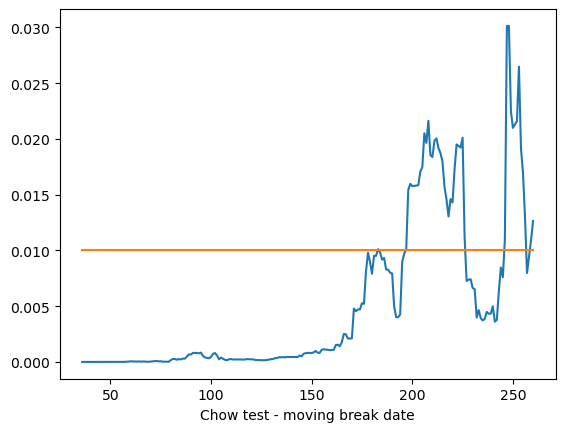

In [81]:
# looping across break dates
w=36
i1=w
i2=n-w
Fstat=np.empty(n-w-w, dtype=float)
Pval=np.empty(n-w-w, dtype=float)
for ii in range(i1,i2):
	XA = np.column_stack((np.ones_like(Y[0:ii]), X1[0:ii], X2[0:ii], X3[0:ii], X4[0:ii], X5[0:ii]))
	XB = np.column_stack((np.ones_like(Y[ii:n]), X1[ii:n], X2[ii:n], X3[ii:n], X4[ii:n], X5[ii:n]))
	Res2A = sm.OLS(Y[0:ii], XA).fit()
	Res2B = sm.OLS(Y[ii:n], XB).fit()
	RSSU=Res2A.ssr+Res2B.ssr
	Fstat[ii-w]=((RSSR-RSSU)/2)/(RSSU/(n-4))
	Pval[ii-w]=1-sp.stats.f.cdf(Fstat[ii-w],2,n-4)

plt.plot(range(i1,i2),Pval,range(i1,i2),0.01*np.ones_like(Pval))
plt.xlabel('Chow test - moving break date')

In [78]:
# Residuals
rs = Res1.resid

# White test
whitetest=sm.stats.diagnostic.het_white(rs,X)
whitetest[1]

# Breusch-Godfrey test
bgtest=sm.stats.diagnostic.acorr_breusch_godfrey(Res1,nlags=3)




In [79]:
# OLS with HAC standard errors
Res2 = sm.OLS(Y, X).fit(cov_type='HAC',cov_kwds={'maxlags':1})
Res2.summary()
Res3 = sm.OLS(Y, X).fit()
Res4 = Res3.get_robustcov_results(cov_type='HAC',maxlags=1)
Res4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.027
Date:                gio, 09 ott 2025   Prob (F-statistic):            0.00150
Time:                        19:13:35   Log-Likelihood:                -1140.8
No. Observations:                 297   AIC:                             2294.
Df Residuals:                     291   BIC:                             2316.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7762      0.752      2.363      0.019       0.297       3.256
X1             0.2138      0.062      3.449      0.001       0.092       0.336
X2             0.0173      0.230      0.075      0.940      -0.435       0.470
X3            -0.3023      2.631     -0.115      0.909      -5.481       4.876
X4            35.5333     12.808      2.774      0.006      10.325      60.742
X5             1.9779      0.981      2.015      0.045       0.046       3.909
==============================================================================
Omnibus:                      154.319   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1745.862
Skew:                          -1.835   Prob(JB):                         0.00
Kurtosis:                      14.296   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

ValueError: x and y must have same first dimension, but have shapes (12,) and (11,)

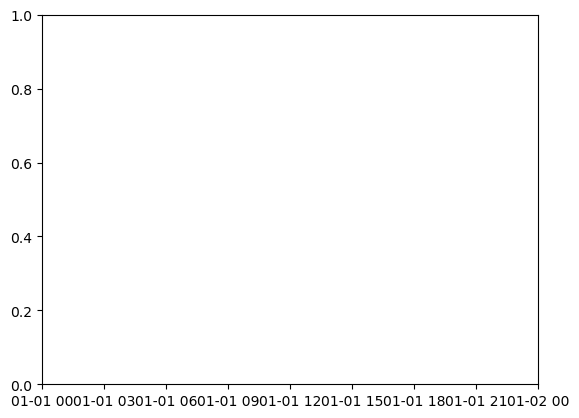

In [80]:
# for forecasting
Yf=Y[286:298]
X1f=X1[286:298]
X2f=X2[286:298]
X3f=X3[286:298]
X4f=X4[286:298]
X5f=X5[286:298]

# in-sample
Y=Y[1:286]
X1=X1[1:286]
X2=X2[1:286]
X3=X3[1:286]
X4=X4[1:286]
X5=X5[1:286]

# forecasting
Xf = np.column_stack((np.ones_like(Yf), X1f, X2f, X3f, X4f, X5f))
Yfhat = Res2.predict(Xf)
fse=Res2.ssr/Res2.df_resid

plt.plot(tf,Yf,tf,Yfhat)